<a href="https://colab.research.google.com/github/LatiefDataVisionary/multivariate-analysis-college-task/blob/main/src/KMeans_w11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Library**

In [23]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

**1. Load Dataset**

In [24]:
path = kagglehub.dataset_download('whenamancodes/predict-diabities')
print(f"Konten/dataset dari downloaded directory '{path}':")
for item in os.listdir(path):
    print(item)

csv_file_path = os.path.join(path, 'diabetes.csv')

Konten/dataset dari downloaded directory '/kaggle/input/predict-diabities':
diabetes.csv


In [25]:
df = pd.read_csv(csv_file_path, usecols=['BloodPressure', 'Age'])
df.head()

,BloodPressure,Age
0,72,50
1,66,31
2,64,32
3,66,21
4,40,33


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   BloodPressure  768 non-null    int64
 1   Age            768 non-null    int64
dtypes: int64(2)
memory usage: 12.1 KB


In [28]:
df.describe()

,BloodPressure,Age
count,768.000000,768.000000
mean,69.105469,33.240885
std,19.355807,11.760232
min,0.000000,21.000000
25%,62.000000,24.000000
50%,72.000000,29.000000
75%,80.000000,41.000000
max,122.000000,81.000000


**2. Data Preprocessing**

Cek missing Values

In [13]:
df.isnull().sum()

,0
BloodPressure,0
Age,0


Standarisasi data

In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['BloodPressure', 'Age']])

**3. Menentukan Jumlah Klaster Optimal (Elbow Metthod) secara otomatis**


Jumlah klaster optimal berdasarkan metode Elbow: k = 2


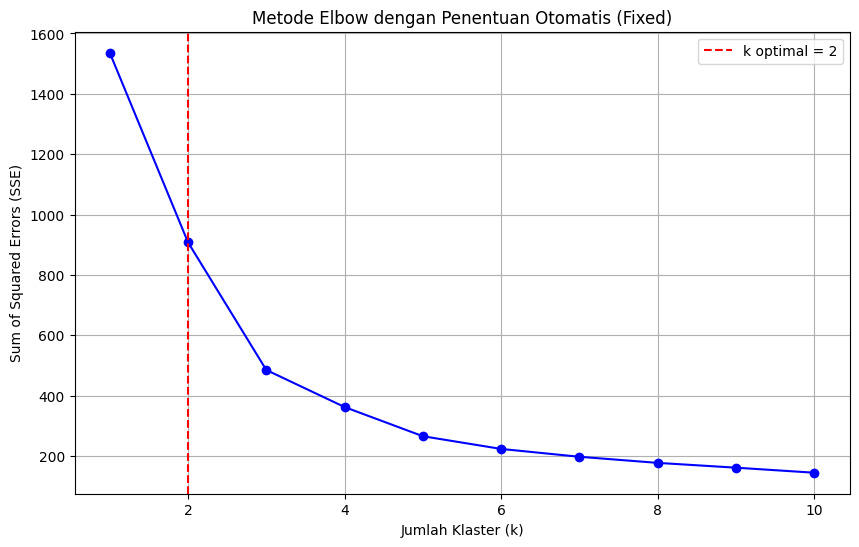

In [22]:
import numpy as np
from sklearn.cluster import KMeans

def find_optimal_k(data, max_k=10):
    """Mencari k optimal secara otomatis menggunakan metode Elbow yang lebih akurat"""
    sse = []
    k_range = range(1, max_k+1)

    # Hitung SSE untuk setiap k
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    # Hitung penurunan persentase SSE
    pct_decrease = []
    for i in range(1, len(sse)):
        decrease = (sse[i-1] - sse[i]) / sse[i-1] * 100
        pct_decrease.append(decrease)

    # Temukan titik di mana penurunan menjadi kurang dari 10%
    # (titik di mana penurunan signifikan berhenti)
    optimal_k = 1
    for i in range(len(pct_decrease)):
        if i > 0:  # Lewati perbandingan pertama
            # Jika penurunan saat ini < 50% dari penurunan sebelumnya
            # DAN penurunan < 10%
            if pct_decrease[i] < 0.5 * pct_decrease[i-1] and pct_decrease[i] < 10:
                optimal_k = i + 1  # +1 karena indeks dimulai dari k=2
                break

    # Fallback jika tidak ditemukan
    if optimal_k == 1 and len(pct_decrease) > 0:
        optimal_k = np.argmax(pct_decrease) + 1

    return optimal_k, sse

# Temukan k optimal secara otomatis
k_optimal, sse = find_optimal_k(scaled_data, max_k=10)
print(f"\nJumlah klaster optimal berdasarkan metode Elbow: k = {k_optimal}")

# Plot hasil untuk verifikasi
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, 'bo-')
plt.axvline(x=k_optimal, color='r', linestyle='--', label=f'k optimal = {k_optimal}')
plt.title('Metode Elbow dengan Penentuan Otomatis (Fixed)')
plt.xlabel('Jumlah Klaster (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.legend()
plt.grid(True)
plt.savefig('elbow_method_auto_fixed.png', dpi=300)
plt.show()